In [1]:
''' Code from Haodong Qin
edited by Iulia Rusu 
'''

import sys, os #, re, glob, socket, glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns





In [2]:
#import sci-kit learn for logistic regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

### 1: Functions needed for geodesic projection

In [3]:
def Mobius_addition(x,y,c):

    # x,y are N-dim vectors, c is the curvature of the hyperbolic space
    # vector addition in hyperbolic space

    top = (1 + 2*c* np.dot(x,y) + c* np.dot(y,y))*x + (1-c*np.dot(x,x))*y
    bottom = 1 + 2*c* np.dot(x,y) + c**2*np.dot(x,x)*np.dot(y,y)
    return top/bottom


def Mobius_scalarMulti(x,r,c):

    # scalar vector multiplication
    # x is a N-dim vector, c is the curvature of the hyperbolic space

    result = 1/np.sqrt(c)*np.tanh(r*np.arctanh(np.sqrt( c*np.dot(x,x) ))) * x/np.sqrt(np.dot(x,x))
    return result 


def Geodesic_distance(x,y,c):
    
    # x,y are N-dim vectors, c is the curvature of the hyperbolic space
    # vector addition in hyperbolic space
    direc_vector = Mobius_addition(-x,y,c)
    dist = 2/np.sqrt(c)*np.arctanh(np.sqrt(c * np.dot(direc_vector,direc_vector) ))

    return dist

def Geodesic_r(t,x,y,c):

    # find the position vector on the geodesic connecting two vectors x and y 
    # when t = 0, final_position = x
    # when t = 1, final_position = y
    direc_vector = Mobius_addition(-x,y,c)

    displace_vector = Mobius_scalarMulti(direc_vector,t,c)

    final_position = Mobius_addition(x,displace_vector,c)

    return final_position

def Geodesic_projection_OptFun(t,x,y,c,p):
    # Function that is needed to optimized to find the geometric projection t
    # x,y are N-dim vectors, c is the curvature of the hyperbolic space
    # geodesic is connecting x and y
    # p is some vector 

    r_geodesic = Geodesic_r(t,x,y,c)

    dist = Geodesic_distance(p,r_geodesic,c)

    return dist


def conformal_factor(x,c):
    # deformation of the mapping from linear to hyperbolic space at position x

    lambda_c_x = 2/(1-c*np.dot(x,x))
    return lambda_c_x

def logarithmic_map(x,y,c):

    # the logarithmic_map will map a position vector y onto the tangent space at x in a hyperbolic space with curvature c
    # logarithmic_map: position in hyperbolic space -> tangent vector in tangent space
    
    minus_x_plus_y = Mobius_addition(-x,y,c)

    length_minus_x_plus_y = np.sqrt(np.dot(minus_x_plus_y,minus_x_plus_y))

    prefactor = 2/np.sqrt(c)/conformal_factor(x,c)*np.arctanh(np.sqrt(c)*length_minus_x_plus_y) 

    tangent_vector = prefactor*minus_x_plus_y/length_minus_x_plus_y

    return tangent_vector

def exponential_map(x,v,c):

    # the exponential_map will map a tangent vector v in the tangent space at x to a position vector in hyperbolic space with curvature c
    # exponential_map: tangent vector in tangent space -> position in hyperbolic space

    # first mapping the tangent vector v in linear space to vector in hyperbolic space
    length_v = np.sqrt(np.dot(v,v))
    constant_1 = np.sqrt(c)*conformal_factor(x,c)*length_v/2
    v_hyp = np.tanh(constant_1)*v/length_v/np.sqrt(c)

    # position vector in hyperbolic space:
    position_vector = Mobius_addition(x,v_hyp,c)

    return position_vector


    

### 3: doing the geometric projection

In [4]:
def hyp_to_hyp_poincare(hyp):

    t = 1
    for coord_idx in hyp.columns:

        t = t + hyp[coord_idx]**2

    t = np.sqrt(t)

    hyp_geo = hyp.copy()

    for coord_idx in hyp_geo.columns:

        hyp_geo[coord_idx] =  hyp_geo[coord_idx]/(1+t)

    return hyp_geo


In [5]:
#access hyp_emb from different notebook
%store -r AVA_RME_pcoords 

In [6]:
AVA_RME_pcoords.shape

(82, 7)

In [45]:
%store -r AVA_RME_pcoords_15dim

In [46]:
#  import your data as dataframe, make sure the columns only include coordinates in the hyperbolic space
df_data = pd.DataFrame(AVA_RME_pcoords_15dim)

# select the point where the tangent space is located, usually at the origin
reference_point_tangent_space =  np.zeros(df_data.shape[1])

In [47]:
# transform the coordinates from native to Poincare ball
hyp_poincare = hyp_to_hyp_poincare(df_data)

# constant, this is fixed, no change
c_hyperbolicSpace = 1

# calculate the tangent vector using logrithmic map
hyp_tangent = hyp_poincare.copy()

for i in range(hyp_poincare.shape[0]):
    current_position_hyp = np.squeeze(hyp_tangent.values[i])
    hyp_tangent.iloc[i] = logarithmic_map(reference_point_tangent_space,current_position_hyp,c_hyperbolicSpace)


In [48]:
hyp_tangent


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.059910,0.039688,0.070826,-0.036956,0.095849,0.140915,-0.082402,-0.023296,-0.028676,-0.016705,-0.011913,-0.081260,-0.018788,0.076888,0.119446
1,-0.088427,0.063832,0.070364,-0.071692,0.095990,0.106182,-0.076903,-0.040886,-0.028277,0.014291,-0.033345,-0.094511,-0.020695,0.044461,0.126719
2,-0.088636,0.056295,0.092110,-0.062542,0.106111,0.135098,-0.067730,-0.003349,-0.031395,0.009671,-0.034005,-0.076276,-0.040515,0.063042,0.087921
3,-0.042977,0.023760,0.071028,-0.020437,0.081887,0.166453,-0.109985,0.014478,-0.035825,-0.034872,-0.014996,-0.066845,-0.031963,0.086816,0.084824
4,-0.048943,0.040930,0.069820,-0.010430,0.076623,0.173578,-0.119081,0.042164,-0.052315,-0.027581,-0.008904,-0.068454,-0.031006,0.073717,0.066819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,-0.063786,-0.035726,-0.039127,0.090807,-0.034751,-0.160623,-0.094842,0.037199,0.031735,-0.012961,-0.084464,0.031195,-0.016405,0.121329,0.043880
78,-0.066254,-0.029631,0.004844,0.093456,-0.032508,-0.184879,-0.060674,-0.023756,0.038647,-0.041773,0.001769,0.024379,-0.074971,0.112321,0.047291
79,-0.070500,0.011073,-0.006037,0.093397,-0.076906,-0.169344,-0.124267,0.010769,0.024638,-0.012088,-0.033125,-0.031610,-0.021810,0.097235,0.081625
80,-0.083426,0.033542,0.014636,0.093487,-0.095900,-0.167416,-0.108687,0.014763,0.010855,-0.017533,-0.011407,-0.052050,-0.035356,0.086382,0.085021


In [10]:
#if you want to graph by label
%store -r AVA_RME_labels 

In [49]:
#if you want to graph by stimulus
%store -r ava_rme_stimuli

In [136]:
#if you want to graph by worm
%store -r AVA_RME_worm_labels

In [137]:
hyp_tangent['stimuli'] = AVA_RME_worm_labels


In [138]:
hyp_tangent['identity'] = AVA_RME_worm_labels

In [139]:
hyp_tangent

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,identity,stimuli
0,-0.059910,0.039688,0.070826,-0.036956,0.095849,0.140915,-0.082402,-0.023296,-0.028676,-0.016705,-0.011913,-0.081260,-0.018788,0.076888,0.119446,worm 0,worm 0
1,-0.088427,0.063832,0.070364,-0.071692,0.095990,0.106182,-0.076903,-0.040886,-0.028277,0.014291,-0.033345,-0.094511,-0.020695,0.044461,0.126719,worm 0,worm 0
2,-0.088636,0.056295,0.092110,-0.062542,0.106111,0.135098,-0.067730,-0.003349,-0.031395,0.009671,-0.034005,-0.076276,-0.040515,0.063042,0.087921,worm 0,worm 0
3,-0.042977,0.023760,0.071028,-0.020437,0.081887,0.166453,-0.109985,0.014478,-0.035825,-0.034872,-0.014996,-0.066845,-0.031963,0.086816,0.084824,worm 0,worm 0
4,-0.048943,0.040930,0.069820,-0.010430,0.076623,0.173578,-0.119081,0.042164,-0.052315,-0.027581,-0.008904,-0.068454,-0.031006,0.073717,0.066819,worm 0,worm 0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,-0.063786,-0.035726,-0.039127,0.090807,-0.034751,-0.160623,-0.094842,0.037199,0.031735,-0.012961,-0.084464,0.031195,-0.016405,0.121329,0.043880,worm 6,worm 6
78,-0.066254,-0.029631,0.004844,0.093456,-0.032508,-0.184879,-0.060674,-0.023756,0.038647,-0.041773,0.001769,0.024379,-0.074971,0.112321,0.047291,worm 6,worm 6
79,-0.070500,0.011073,-0.006037,0.093397,-0.076906,-0.169344,-0.124267,0.010769,0.024638,-0.012088,-0.033125,-0.031610,-0.021810,0.097235,0.081625,worm 6,worm 6
80,-0.083426,0.033542,0.014636,0.093487,-0.095900,-0.167416,-0.108687,0.014763,0.010855,-0.017533,-0.011407,-0.052050,-0.035356,0.086382,0.085021,worm 6,worm 6


In [140]:
data = hyp_tangent

In [54]:
data[data['identity'] == 'stimulus 0'].iloc[:, 0:15].head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.059910,0.039688,0.070826,-0.036956,0.095849,0.140915,-0.082402,-0.023296,-0.028676,-0.016705,-0.011913,-0.081260,-0.018788,0.076888,0.119446
1,-0.088427,0.063832,0.070364,-0.071692,0.095990,0.106182,-0.076903,-0.040886,-0.028277,0.014291,-0.033345,-0.094511,-0.020695,0.044461,0.126719
2,-0.088636,0.056295,0.092110,-0.062542,0.106111,0.135098,-0.067730,-0.003349,-0.031395,0.009671,-0.034005,-0.076276,-0.040515,0.063042,0.087921
3,-0.042977,0.023760,0.071028,-0.020437,0.081887,0.166453,-0.109985,0.014478,-0.035825,-0.034872,-0.014996,-0.066845,-0.031963,0.086816,0.084824
4,-0.048943,0.040930,0.069820,-0.010430,0.076623,0.173578,-0.119081,0.042164,-0.052315,-0.027581,-0.008904,-0.068454,-0.031006,0.073717,0.066819


In [78]:
# ON_means= np.mean(data.values[0:29, :], axis = 0)
#caluclate means across the column

RME_means = data[data['identity'] == 'RME'].iloc[:, 0:15].mean(axis=0)

In [79]:
RME_means = np.array(RME_means)

In [80]:
AVA_means = data[data['identity'] == 'AVA'].iloc[:, 0:15].mean(axis=0)

In [81]:
AVA_means = np.array(AVA_means)

In [116]:
#subtract RME from AVA
diff_means = AVA_means[0:15] - RME_means[0:15]

In [141]:
diff_means

array([ 0.0070911 , -0.01590113,  0.00154107, -0.01903801,  0.00511294,
       -0.00233021, -0.01517368, -0.02447462, -0.03884962, -0.0350067 ,
       -0.03564069,  0.01172047, -0.00477295, -0.0048514 , -0.00516672])

In [117]:
#normalize the difference
normalized = diff_means/np.linalg.norm(diff_means)

In [118]:
normalized

array([ 0.0935621 , -0.20980426,  0.02033329, -0.2511932 ,  0.06746166,
       -0.03074548, -0.20020605, -0.32292538, -0.51259341, -0.46188878,
       -0.47025392,  0.15464335, -0.0629757 , -0.06401085, -0.06817128])

In [119]:
axis_trans = np.dot(data.values[:, 0:15], normalized)

In [120]:
axis_trans.shape

(82,)

In [127]:
clust_labs_reshaped = ava_rme_stimuli[:, np.newaxis]
clust_labs_reshaped.shape

(82, 1)

In [128]:
axis_trans_reshaped = axis_trans[:, np.newaxis]

In [129]:
combined_array = np.concatenate((axis_trans_reshaped, clust_labs_reshaped), axis=1)

In [130]:
axis_trans_df = pd.DataFrame(combined_array)

In [131]:
axis_trans_df

,0,1
0,0.026514,stimulus 0
1,0.028361,stimulus 0
2,0.023469,stimulus 0
3,0.037182,stimulus 0
4,0.026767,stimulus 0
...,...,...
77,0.01203,stimulus 0
78,-0.003319,stimulus 0
79,-0.017855,stimulus 0
80,-0.031608,stimulus 0


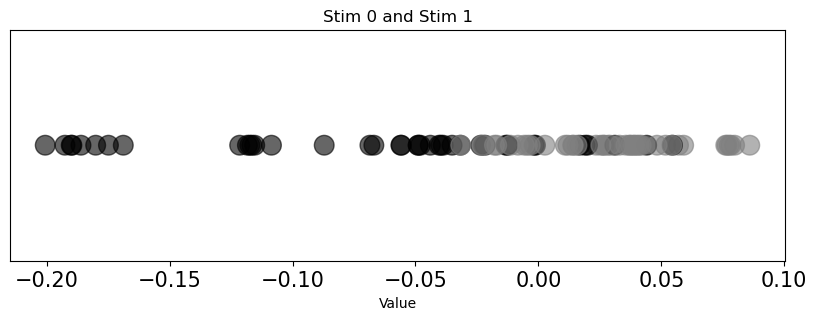

In [135]:
axis_trans_df.columns = ['Value', 'Category']

# Create a color map manually
color_map = {
    'stimulus 0': 'grey',  # Color for 'RME'
    'stimulus 1': 'black'  # Color for 'AVA'
}

# Map labels to colors using the color map
label_colors = axis_trans_df['Category'].map(color_map)

# Create scatter plot with specified figure size
fig, ax = plt.subplots(figsize=(10, 3))
ax.scatter(axis_trans_df['Value'], [0] * len(axis_trans_df), c=label_colors, s=200, alpha = 0.6)
ax.set_xlabel('Value')
plt.xticks(fontsize=15 )
ax.yaxis.set_visible(False)




# Add legend to plot


ax.set_title('Stim 0 and Stim 1')

plt.show()



In [63]:
axis_trans_df

,Value,Category
0,0.093545,AVA
1,0.089763,AVA
2,-0.016134,AVA
3,0.139165,AVA
4,0.107323,AVA
...,...,...
64,0.17609,RME
65,0.148105,RME
66,0.26241,RME
67,0.218891,RME


In [94]:
RME = axis_trans_df[axis_trans_df['Category'] == 'RME']['Value']
AVA = axis_trans_df[axis_trans_df['Category'] == 'AVA']['Value']





(array([0., 1., 2., 3., 4., 5., 6., 7., 8.]),
 [Text(0, 0.0, '0'),
  Text(0, 1.0, '1'),
  Text(0, 2.0, '2'),
  Text(0, 3.0, '3'),
  Text(0, 4.0, '4'),
  Text(0, 5.0, '5'),
  Text(0, 6.0, '6'),
  Text(0, 7.0, '7'),
  Text(0, 8.0, '8')])

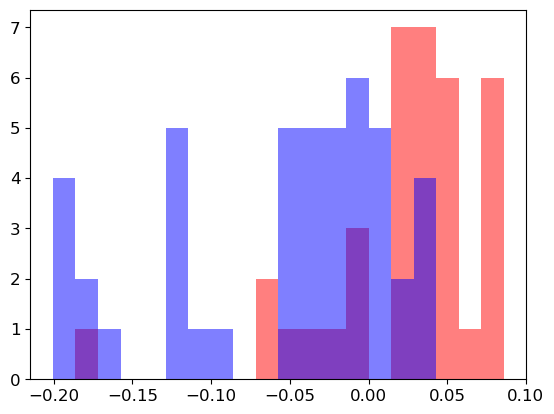

In [102]:
plt.hist([RME, AVA], bins = 20, alpha=0.5, label=['RME', 'AVA'], color = [ 'blue','red'], histtype='stepfilled')
plt.xticks(fontsize=12 )
plt.yticks(fontsize=12 )


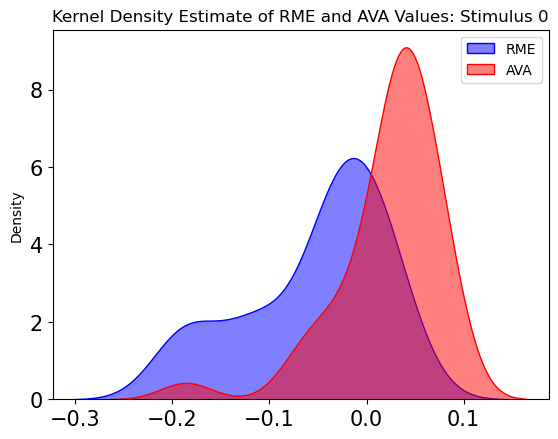

In [103]:
# Plotting KDE for each category
sns.kdeplot(RME, color='blue', fill=True, alpha=0.5, label='RME')
sns.kdeplot(AVA, color='red', fill=True, alpha=0.5, label='AVA')

# Adding labels and title
plt.xlabel('')
plt.ylabel('Density')
plt.xticks(fontsize=15 )
plt.yticks(fontsize=15 )
plt.title('Kernel Density Estimate of RME and AVA Values: Stimulus 0')
plt.legend()

# Show the plot
plt.show()

#what should the x-axis be?

In [ ]:
#look at distance between distributions, KS distance 

In [136]:
#use svm in 8 dim space 
#also try a logistic regression, using 8 dim tangent space data and correspoding labels
#try MNE on tangent space coords
y = data.iloc[:, -1]
X = data.iloc[:, 0:5]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [138]:
logreg = LogisticRegression(random_state=16)

# Train the model
logreg.fit(X_train, y_train)

LogisticRegression(random_state=16)

In [139]:
logreg.fit(X_train, y_train)

LogisticRegression(random_state=16)

In [140]:
y_pred = logreg.predict(X_test)

In [141]:
y_pred

array(['RME', 'RME', 'AVA', 'RME', 'AVA', 'AVA', 'AVA', 'AVA', 'AVA',
       'AVA', 'AVA', 'AVA', 'RME', 'AVA', 'RME'], dtype=object)

In [143]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[4, 1],
       [6, 4]])

NameError: name 'Text' is not defined

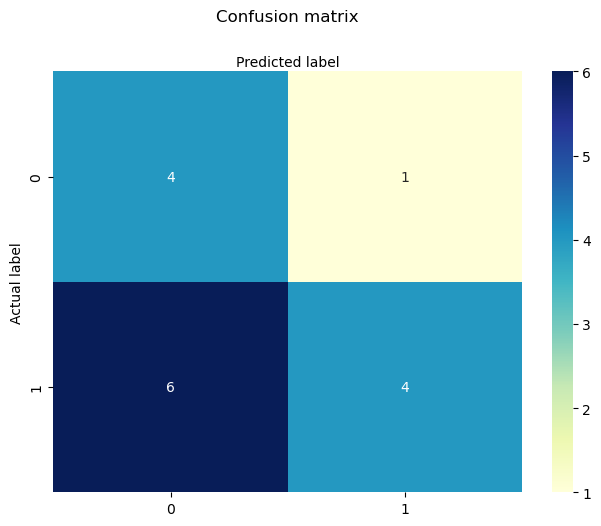

In [144]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Text(0.5,257.44,'Predicted label');

In [149]:
target_names = ['AVA', 'RME']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         AVA       0.40      0.80      0.53         5
         RME       0.80      0.40      0.53        10

    accuracy                           0.53        15
   macro avg       0.60      0.60      0.53        15
weighted avg       0.67      0.53      0.53        15

